# Precision-Recall Curve: Evaluación Visual del Trade-off en Clasificación

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)

# Configuración general
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)

print("=== ANÁLISIS DE CURVAS PRECISION-RECALL Y SELECCIÓN DE UMBRAL ===\n")


=== ANÁLISIS DE CURVAS PRECISION-RECALL Y SELECCIÓN DE UMBRAL ===



In [4]:
# Simulación: detección de fraude (1% positivos)
X, y = make_classification(
    n_samples=10_000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_clusters_per_class=1,
    weights=[0.99, 0.01],
    flip_y=0.01,
    random_state=42
)

print(f"Distribución de clases:")
print(f"Clase 0 (Normal): {np.sum(y == 0)} ({np.mean(y == 0):.1%})")
print(f"Clase 1 (Fraude): {np.sum(y == 1)} ({np.mean(y == 1):.1%})")

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


Distribución de clases:
Clase 0 (Normal): 9861 (98.6%)
Clase 1 (Fraude): 139 (1.4%)


In [6]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    auc_pr = average_precision_score(y_test, y_proba)

    results[name] = {
        'precision': precision,
        'recall': recall,
        'thresholds': thresholds,
        'auc_pr': auc_pr,
        'y_proba': y_proba
    }

    print(f"{name:20}: AUC-PR = {auc_pr:.4f}")


Random Forest       : AUC-PR = 0.4651
Logistic Regression : AUC-PR = 0.4932


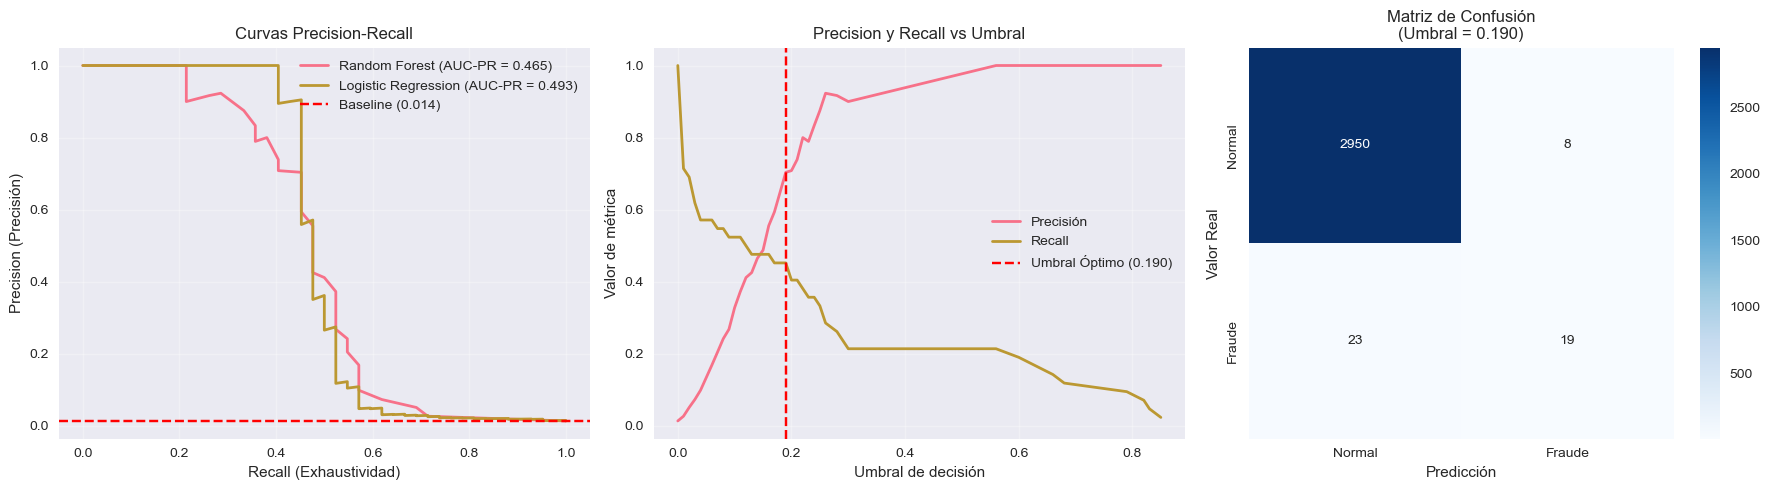

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
baseline = np.mean(y_test)

# --- Subplot 1: Curvas Precision-Recall ---
ax1 = axes[0]
for name, res in results.items():
    ax1.plot(res['recall'], res['precision'], lw=2,
             label=f'{name} (AUC-PR = {res["auc_pr"]:.3f})')
ax1.axhline(y=baseline, color='red', ls='--', label=f'Baseline ({baseline:.3f})')
ax1.set_xlabel('Recall (Exhaustividad)')
ax1.set_ylabel('Precision (Precisión)')
ax1.set_title('Curvas Precision-Recall')
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- Subplot 2: Análisis de umbrales (Random Forest) ---
rf = results['Random Forest']
precision, recall, thresholds = rf['precision'], rf['recall'], rf['thresholds']
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

ax2 = axes[1]
ax2.plot(thresholds, precision[:-1], lw=2, label='Precisión')
ax2.plot(thresholds, recall[:-1], lw=2, label='Recall')
ax2.axvline(x=optimal_threshold, color='red', ls='--',
            label=f'Umbral Óptimo ({optimal_threshold:.3f})')
ax2.set_xlabel('Umbral de decisión')
ax2.set_ylabel('Valor de métrica')
ax2.set_title('Precision y Recall vs Umbral')
ax2.legend()
ax2.grid(True, alpha=0.3)

# --- Subplot 3: Matriz de Confusión ---
y_pred_opt = (rf['y_proba'] >= optimal_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_opt)
ax3 = axes[2]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=['Normal', 'Fraude'],
            yticklabels=['Normal', 'Fraude'])
ax3.set_title(f'Matriz de Confusión\n(Umbral = {optimal_threshold:.3f})')
ax3.set_xlabel('Predicción')
ax3.set_ylabel('Valor Real')

plt.tight_layout()
plt.show()


In [10]:
print("\n" + "="*60)
print("ANÁLISIS DETALLADO DE RENDIMIENTO")
print("="*60)

for name, res in results.items():
    print(f"\n{name}:")
    print(f"  • AUC-PR: {res['auc_pr']:.4f}")

    y_pred = (res['y_proba'] >= 0.5).astype(int)
    report = classification_report(y_test, y_pred, output_dict=True)

    print(f"  • Precision (0.5): {report['1']['precision']:.4f}")
    print(f"  • Recall (0.5): {report['1']['recall']:.4f}")
    print(f"  • F1-Score (0.5): {report['1']['f1-score']:.4f}")



ANÁLISIS DETALLADO DE RENDIMIENTO

Random Forest:
  • AUC-PR: 0.4651
  • Precision (0.5): 1.0000
  • Recall (0.5): 0.2143
  • F1-Score (0.5): 0.3529

Logistic Regression:
  • AUC-PR: 0.4932
  • Precision (0.5): 1.0000
  • Recall (0.5): 0.4048
  • F1-Score (0.5): 0.5763


In [12]:
print("\n" + "="*60)
print("SELECCIÓN DE UMBRAL BASADA EN REQUISITOS DE NEGOCIO")
print("="*60)

precision, recall, thresholds = rf['precision'], rf['recall'], rf['thresholds']

# Escenario 1: Alta precisión (≥80%)
idx_high_precision = np.where(precision >= 0.8)[0]
if len(idx_high_precision) > 0:
    idx = idx_high_precision[0]
    print(f"\nEscenario 1 - Alta Precisión (≥80%)")
    print(f"  • Umbral: {thresholds[idx]:.4f}")
    print(f"  • Precision: {precision[idx]:.4f}")
    print(f"  • Recall: {recall[idx]:.4f}")
    print(f"  • Interpretación: Detectamos {recall[idx]*100:.1f}% de fraudes con 80%+ certeza")

# Escenario 2: Alto recall (≥90%)
idx_high_recall = np.where(recall >= 0.9)[0]
if len(idx_high_recall) > 0:
    idx = idx_high_recall[-1]
    print(f"\nEscenario 2 - Alto Recall (≥90%)")
    print(f"  • Umbral: {thresholds[idx]:.4f}")
    print(f"  • Precision: {precision[idx]:.4f}")
    print(f"  • Recall: {recall[idx]:.4f}")
    print(f"  • Interpretación: Detectamos 90%+ de fraudes con {(1 - precision[idx])*100:.1f}% falsas alarmas")



SELECCIÓN DE UMBRAL BASADA EN REQUISITOS DE NEGOCIO

Escenario 1 - Alta Precisión (≥80%)
  • Umbral: 0.2200
  • Precision: 0.8000
  • Recall: 0.3810
  • Interpretación: Detectamos 38.1% de fraudes con 80%+ certeza

Escenario 2 - Alto Recall (≥90%)
  • Umbral: 0.0000
  • Precision: 0.0140
  • Recall: 1.0000
  • Interpretación: Detectamos 90%+ de fraudes con 98.6% falsas alarmas


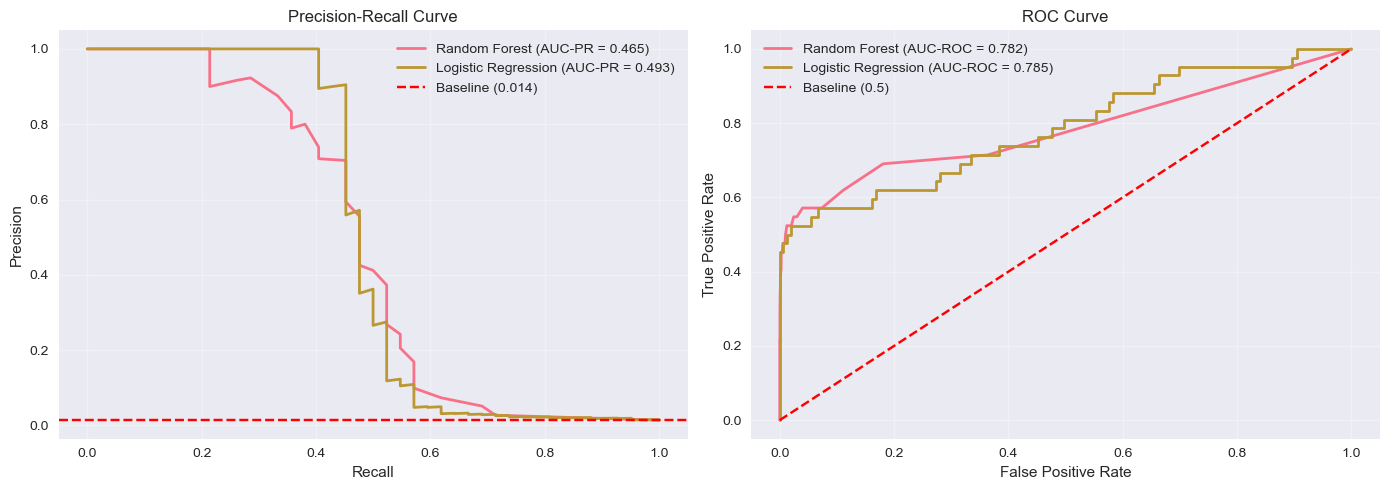


Observación:
En datasets desbalanceados, la curva ROC puede parecer buena (AUC alto),
pero la curva PR muestra la verdadera capacidad para detectar la clase minoritaria.


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Curvas Precision-Recall
ax1 = axes[0]
for name, res in results.items():
    ax1.plot(res['recall'], res['precision'], lw=2,
             label=f'{name} (AUC-PR = {res["auc_pr"]:.3f})')
ax1.axhline(y=baseline, color='red', ls='--', label=f'Baseline ({baseline:.3f})')
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall Curve')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Curvas ROC
ax2 = axes[1]
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_proba'])
    auc_roc = roc_auc_score(y_test, res['y_proba'])
    ax2.plot(fpr, tpr, lw=2, label=f'{name} (AUC-ROC = {auc_roc:.3f})')
ax2.plot([0, 1], [0, 1], 'r--', label='Baseline (0.5)')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservación:")
print("En datasets desbalanceados, la curva ROC puede parecer buena (AUC alto),")
print("pero la curva PR muestra la verdadera capacidad para detectar la clase minoritaria.")
